<a href="https://colab.research.google.com/github/Raanjeetsgolu/CNN-Face-Recognation.ipynb/blob/main/FaceRecognation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup

## 1.1 Install Dependencies

In [4]:
#getting file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!cp -r /content/drive/MyDrive/Face-recogniation/data  /content

In [5]:
#installing the opencv and tensorflow
!pip install tensorflow==2.15.0  opencv-python matplotlib

## 1.2 Import Dependencies

In [6]:
# Import  dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures for images

In [8]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [9]:
# Make the directories to store images
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Downloading LFW image data and setting images in respective directory

In [10]:
#Downloading data from the Labeled Faces in the Wild  dataset
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2024-05-12 18:45:47--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  2.80MB/s    in 67s     

2024-05-12 18:46:54 (2.58 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [11]:
# Uncompress Tar gz  data from the Labeled Faces in the Wild  dataset that we downloaded before.
!tar -xf lfw.tgz

In [9]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [91]:
# Import uuid library to generate unique image names
import uuid

In [92]:
# Function to capture image and crop the image 250*250
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(output_folder, quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  # filename = str(uuid.uuid1()) + '.jpg'
  filename = os.path.join(output_folder, '{}.jpg'.format(uuid.uuid1()))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  # return filename


  frame = cv2.imread(filename)

  # Crop the image to 250x250 pixels
  cropped_frame = frame[120:370, 200:450, :]  # Adjust the slicing indices as needed

  # Save the cropped image
  cv2.imwrite(filename, cropped_frame)

  return filename

In [14]:
from IPython.display import Image
def saveImages(number_of_image, path_to_store):
  for  i in range(number_of_image):
    try:

      filename = take_photo(path_to_store)
      print('Saved to {}'.format(filename))

      # Show the image which was just taken.
      display(Image(filename))
    except Exception as err:
      print(str(err))
    i +=1

In [ ]:
#Capture and store  positive images
saveImages(50,POS_PATH)

In [ ]:
#Capture and store anchor image
saveImages(50,ANC_PATH)

# 3. Load and Preprocess Images

## 3.1 Getting Image Directories

In [15]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(35)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(35)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(35)

In [16]:
dir_test = anchor.as_numpy_iterator()

## 3.2 Preprocessing images - Scale and Resize

---



In [17]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [19]:
#for a example
img = preprocess('/content/data/anchor/1c3fa7bc-f05f-11ee-b446-0242ac1c000c.jpg')

In [ ]:
plt.imshow(img)

## 3.3 Create Labelled Dataset

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [20]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [21]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [22]:
#one sample of our data
samples = data.as_numpy_iterator()

In [23]:
example = samples.next()

In [24]:
example

(b'data/anchor/be8c376c-f05d-11ee-b446-0242ac1c000c.jpg',
 b'data/positive/59ea1ee4-f433-11ee-ba4e-0242ac1c000c.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [25]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [26]:
res = preprocess_twin(*example)

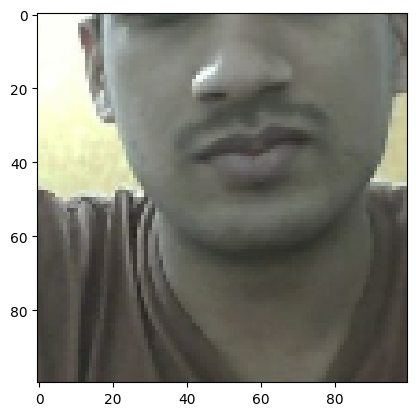

In [27]:
plt.imshow(res[0])

In [45]:
res[2]

1.0

In [28]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [29]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [30]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(10)
test_data = test_data.prefetch(5)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [31]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [32]:
embedding = make_embedding()

In [33]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [34]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # calculating similarity
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [79]:
l1 = L1Dist()

In [80]:
l1

## 4.3 Make Siamese Model

In [37]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [38]:
siamese_model = make_siamese_model()

In [39]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 5. Training

## 5.1 Setup Loss and Optimizer

In [40]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [41]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [42]:
# creating a directory
!mkdir 'training_checkpoints'

In [43]:
checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [44]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

## 5.4 Build Training Loop

In [45]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [46]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [47]:
EPOCHS = 28

In [48]:
train(train_data, EPOCHS)


 Epoch 1/28
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
4/4 [==============================] - 153s 34s/step
0.68080974 0.8076923 1.0

 Epoch 2/28
4/4 [==============================] - 139s 31s/step
0.68297756 1.0 1.0

 Epoch 3/28
4/4 [==============================] - 141s 32s/step
0.59179944 0.92 1.0

 Epoch 4/28
4/4 [==============================] - 139s 31s/step
0.14601417 0.9130435 1.0

 Epoch 5/28
4/4 [==============================] - 142s 33s/step
0.033441395 0.9 1.0

 Epoch 6/28
4/4 [==============================] - 137s 31s/step
0.055731766 0.9285714 1.0

 Epoch 7/28
4/4 [==============================] - 139s 32s/step
0.033060398 1.0 0.95652175

 Epoch 8/28
4/4 [==============================] - 141s 32s/step
0.07775123 0.9583333 1.0

 Epoch 9/28
4/4 [==============================] - 135s 30s/step
0.11901586 0.9583333 1.0

 Epoch 10/28
4/4 [=====================

# 6. Evaluate Model

## 6.1 Import Metrics

In [49]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [66]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [67]:
test_input

array([[[[1.        , 1.        , 0.8257353 ],
         [0.9796569 , 0.98357844, 0.83112746],
         [0.7316176 , 0.7289216 , 0.6389706 ],
         ...,
         [0.65392154, 0.5127451 , 0.34901962],
         [0.65686274, 0.50392157, 0.34313726],
         [0.65612745, 0.5110294 , 0.34632352]],

        [[1.        , 1.        , 0.8487745 ],
         [0.97132355, 0.9703431 , 0.839951  ],
         [0.58455884, 0.57965684, 0.4987745 ],
         ...,
         [0.6911765 , 0.5441176 , 0.37892157],
         [0.6767157 , 0.5237745 , 0.3629902 ],
         [0.67156863, 0.5264706 , 0.3617647 ]],

        [[0.9997549 , 0.9997549 , 0.8727941 ],
         [0.8723039 , 0.86740196, 0.7625    ],
         [0.45931372, 0.44607842, 0.39142156],
         ...,
         [0.69411767, 0.5470588 , 0.3759804 ],
         [0.6840686 , 0.5355392 , 0.37107843],
         [0.67009807, 0.5264706 , 0.3617647 ]],

        ...,

        [[0.70906866, 0.6012255 , 0.43357843],
         [0.71666664, 0.60882354, 0.4377451 ]

In [68]:
test_var =  test_data.as_numpy_iterator().next()

In [69]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


In [70]:
y_hat

array([[7.0325994e-05],
       [9.9999994e-01],
       [6.1866854e-06],
       [2.5542204e-07],
       [9.9999940e-01],
       [1.0565318e-03],
       [9.9999738e-01],
       [9.9999666e-01],
       [2.4900130e-05],
       [4.6043176e-08]], dtype=float32)

In [71]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 0, 1, 0, 1, 1, 0, 0]

In [72]:
y_true

array([0., 1., 0., 0., 1., 0., 1., 1., 0., 0.], dtype=float32)

## 6.3 Calculate Metrics

In [73]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [74]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [59]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 235ms/step
1.0 1.0


## 6.4 Viz Results

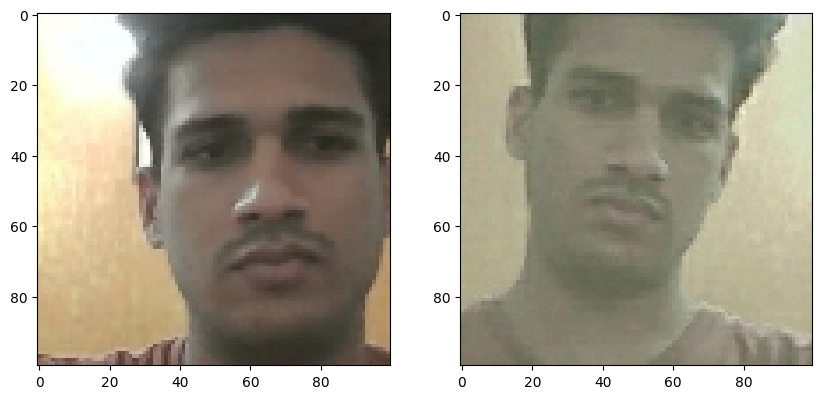

In [76]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()

# 7. Save Model

In [77]:
# Save weights
siamese_model.save('siamesemodelv1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [82]:
# Reload model
siamese_model = tf.keras.models.load_model('siamesemodelv1.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [83]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


array([[7.0325994e-05],
       [9.9999994e-01],
       [6.1866854e-06],
       [2.5542204e-07],
       [9.9999940e-01],
       [1.0565318e-03],
       [9.9999738e-01],
       [9.9999666e-01],
       [2.4900130e-05],
       [4.6043176e-08]], dtype=float32)

In [ ]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 8. Real Time Test

## 8.1 Verification Function

In [84]:
VERIFICATION_IMAGE_PATH=os.path.join('application_data', 'verification_images')
INPUT_IMAGE_PATH=os.path.join('application_data', 'input_image')

In [85]:
#creating application flfer
os.makedirs(VERIFICATION_IMAGE_PATH)
os.makedirs(INPUT_IMAGE_PATH)

In [86]:
!cp -r /content/drive/MyDrive/Face-recogniation/data/positive  /content/application_data/

In [87]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

## 8.2  Real Time Verification

---



In [ ]:
from IPython.display import Image

FOLDER_PATH = '/content/application_data/input_image'

try:
    filename = take_photo(FOLDER_PATH)
    new_filename = os.path.join(FOLDER_PATH, 'input_image.jpg')
    os.rename(filename, new_filename)
    results, verified = verify(siamese_model, 0.9, 0.7)
    print(verified)

    # Show the image which was just taken.
    display(Image(new_filename))
except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))
